In [ ]:
!apt -qq install -y sox
!pip install sox
!pip install config
!pip install torchmetrics

In [ ]:
# All imports + mounts drive

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torchmetrics.classification import MulticlassAccuracy
from torchmetrics.classification import MulticlassConfusionMatrix

import io
import os
import math
import tarfile
import multiprocessing
import librosa
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Class for IEMOCAP object + statistics functions

class IemocapDataset(object):
    'Create a Dataset for Iemocap. Each item is a tuple of the form:'
    '(waveform, sample_rate, emotion, activation, valence, dominance)'
    
    _ext_audio = '.wav'
    _emotions = { 'ang': 0, 'hap': 1, 'exc': 2, 'sad': 3, 'fru': 4, 'fea': 5, 'sur': 6, 'neu': 7, 'xxx': 8 }

    def __init__(self,
                 root='IEMOCAP_full_release',
                 emotions=['ang', 'hap', 'exc', 'sad', 'fru', 'fea', 'sur', 'neu', 'xxx'],
                 sessions=[1, 2, 3, 4, 5],
                 script_impro=['script', 'impro'],
                 genders=['M', 'F']):
        """
        Args:
            root (string): Directory containing the Session folders
        """
        self.root = root

        # Iterate through all 5 sessions
        data = []
        for i in [5]:
            # Define path to evaluation files of this session
            path = os.path.join(root, 'Session' + str(i), 'dialog', 'EmoEvaluation')

            # Get list of evaluation files
            files = [file for file in os.listdir(path) if file.endswith('.txt')]

            # Iterate through evaluation files to get utterance-level data
            for file in files:
                # Open file
                f = open(os.path.join(path, file), 'r')

                # Get list of lines containing utterance-level data. Trim and split each line into individual string elements.
                data += [line.strip()
                             .replace('[', '')
                             .replace(']', '')
                             .replace(' - ', '\t')
                             .replace(', ', '\t')
                             .split('\t')
                         for line in f if line.startswith('[')]

        # Get session number, script/impro, speaker gender, utterance number
        data = [d + [d[2][4], d[2].split('_')[1], d[2][-4], d[2][-3:]] for d in data]

        # Create pandas dataframe
        self.df = pd.DataFrame(data, columns=['start', 'end', 'file', 'emotion', 'activation', 'valence', 'dominance', 'session', 'script_impro', 'gender', 'utterance'], dtype=np.float32)

        # Filter by emotions
        filtered_emotions = self.df['emotion'].isin(emotions)
        self.df = self.df[filtered_emotions]

        # Filter by sessions
        filtered_sessions = self.df['session'].isin(sessions)
        self.df = self.df[filtered_sessions]

        # Filter by script_impro
        filtered_script_impro = self.df['script_impro'].str.contains('|'.join(script_impro))
        self.df = self.df[filtered_script_impro]

        # Filter by gender
        filtered_genders = self.df['gender'].isin(genders)
        self.df = self.df[filtered_genders]

        # Reset indices
        self.df = self.df.reset_index()

        # Map emotion labels to numeric values
        self.df['emotion'] = self.df['emotion'].map(self._emotions).astype(np.float32)

        # Map file to correct path w.r.t to root
        self.df['file'] = [os.path.join('Session' + file[4], 'sentences', 'wav', file[:-5], file + self._ext_audio) for file in self.df['file']]

    def sort_by_emo(self):  
        emo_dict = {}

        for i in [0,1,2,3,4,7]:
            emo_dict[i] = self.df['emotion'].value_counts()[i]

        emo_dict['anger'] = emo_dict.pop(0)
        emo_dict['happiness'] = emo_dict.pop(1)
        emo_dict['excitment'] = emo_dict.pop(2)
        emo_dict['sadness'] = emo_dict.pop(3)
        emo_dict['frustration'] = emo_dict.pop(4)
        #emo_dict['fear'] = emo_dict.pop(5)
        #emo_dict['surprise'] = emo_dict.pop(6)
        emo_dict['neutral'] = emo_dict.pop(7)
        #emo_dict['other'] = emo_dict.pop(8)

        emo_dict2 = {'anger + frustration': emo_dict['anger'] + emo_dict['frustration'],
                     'happiness + excitment': emo_dict['happiness'] + emo_dict['excitment'],
                     'sadness': emo_dict['sadness'],
                     'neutral': emo_dict['neutral']}
        return emo_dict, emo_dict2

    def len_histogram(self):
        lens = []
        for index, row in self.df.iterrows():
            sample = self.__getitem__(index)
            lens.append(sample['waveform'].shape[1])
        fig = plt.hist(lens)
        return fig

    def short_long(self):
        min = np.inf
        max = 0
        for index, row in self.df.iterrows():
            sample = self.__getitem__(index)
            wf = sample['waveform'].shape[1]
            if wf > max:
                max = wf
            elif wf < min:
                min = wf     
        return min, max
      
    def del_item(self):
        for index, row in self.df.iterrows():
            if int(self.df.loc[index, 'emotion']) == int(5) or int(6) or int(8):
                self.df.drop(index = [index])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        audio_name = os.path.join(self.root, self.df.loc[idx, 'file'])
        waveform, sample_rate = torchaudio.load(audio_name)
        emotion = self.df.loc[idx, 'emotion']
        activation = self.df.loc[idx, 'activation']
        valence = self.df.loc[idx, 'valence']
        dominance = self.df.loc[idx, 'dominance']

        sample = {
            'path': audio_name,
            'waveform': waveform,
            'sample_rate': sample_rate,
            'emotion': emotion,
            'activation': activation,
            'valence': valence,
            'dominance': dominance
        }
        return sample

# Adapted from torchemotion public repo by Alan Tan
# https://github.com/alantanlc/torchemotion/blob/master/datasets/IemocapDataset.py

In [ ]:
# Initialize IEMOCAP dataset object and calculate statistics

iemocap_dataset = IemocapDataset('/content/drive/MyDrive/dl_final_project_s23/IEMOCAP')
print(iemocap_dataset.sort_by_emo()[1])
print(iemocap_dataset.len_histogram())
print(iemocap_dataset.short_long())

# Removes samples labeled fear, surprise, and other (too few samples)
print(iemocap_dataset.__len__())
iemocap_dataset.df.drop(iemocap_dataset.df[iemocap_dataset.df['emotion'] == 5].index, inplace = True)
iemocap_dataset.df.drop(iemocap_dataset.df[iemocap_dataset.df['emotion'] == 6].index, inplace = True)
iemocap_dataset.df.drop(iemocap_dataset.df[iemocap_dataset.df['emotion'] == 8].index, inplace = True)

# Reset indexing
iemocap_dataset.df = iemocap_dataset.df.reset_index(drop = True)
print(iemocap_dataset.__len__())

# Function that creates input matrix (calculates parameters, reassigns labels, returns matrix and label as tuple)
def create_matrix(index, n):
    'index = number of sample, n = number of frames for each sample'
    'creates input matrix for each sample'
    emotion = iemocap_dataset.__getitem__(index)['emotion']
    if emotion == 0 or emotion == 4:
        emotion = 0 #anger/frustration
    elif emotion == 1 or emotion == 2:
        emotion = 1 #happiness/excitement
    elif emotion == 3:
        emotion = 2 #sadness
    elif emotion == 7:
        emotion = 3 #neutral
    waveform = iemocap_dataset.__getitem__(index)['waveform']
    original_size = waveform.shape[1]
    remainder = np.mod(original_size, n)
    padding = n - remainder - 1
    waveform = F.pad(waveform, (0, padding))
    hop_len = int(np.round(waveform.shape[1]/n))
    mfcc = librosa.feature.mfcc(y = waveform.numpy(), n_mfcc = 128, win_length = 512, hop_length = hop_len)
    flatness = librosa.feature.spectral_flatness(y = waveform.numpy(), win_length = 512, hop_length = hop_len)
    bandwidth = librosa.feature.spectral_bandwidth(y = waveform.numpy(), sr = 16000, win_length = 512, hop_length = hop_len)
    centroid = librosa.feature.spectral_centroid(y = waveform.numpy(), sr = 16000, win_length = 512, hop_length = hop_len)
    contrast = librosa.feature.spectral_contrast(y = waveform.numpy(), sr = 16000, win_length = 512, hop_length = hop_len, n_bands = 6)
    rolloff = librosa.feature.spectral_rolloff(y = waveform.numpy(), sr = 16000, win_length = 512, hop_length = hop_len)
    frms = librosa.feature.rms(y = waveform.numpy(), frame_length = 512, hop_length = hop_len)
    matrix = np.concatenate((mfcc, flatness, bandwidth, centroid, contrast, rolloff, frms), axis = 1)
    return matrix, emotion

2170
{'anger + frustration': 551, 'happiness + excitment': 442, 'sadness': 245, 'neutral': 384}
7.0
2170
1622
{'anger': 170, 'happiness': 143, 'excitment': 299, 'sadness': 245, 'frustration': 381, 'neutral': 384}


<ipython-input-2-e7807b9585d7>:52: FutureWarning: Could not cast to float32, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  self.df = pd.DataFrame(data, columns=['start', 'end', 'file', 'emotion', 'activation', 'valence', 'dominance', 'session', 'script_impro', 'gender', 'utterance'], dtype=np.float32)


In [ ]:
# Uses create_matrix to process entire dataset

data = []
for i in range(len(iemocap_dataset)):
    matrix, emotion = create_matrix(i, 512)
    matrix = torch.nn.functional.normalize(torch.from_numpy(np.squeeze(matrix)), dim=1) # normalize values (0-1)
    data.append((matrix, emotion))


# Random split into 20% testing, 80% training
test, train = torch.utils.data.random_split(data, [0.2, 0.8])
print(len(test))
print(len(train))

# Use DataLoader to make shuffled batches
batched_train = torch.utils.data.DataLoader(train, batch_size = 20)
batched_test = torch.utils.data.DataLoader(test, batch_size = len(test))

1622
325


In [ ]:
# GRU model class

class EmoGRUModel(nn.Module):
    def __init__(self, input_size, epochs = 5):
        super().__init__()

        self.input_size = input_size
        self.epochs = epochs

        self.loss = nn.CrossEntropyLoss()
        self.accuracy = MulticlassAccuracy(4)

        # GRU layers
        self.bn = nn.BatchNorm1d(140, dtype=torch.double)
        self.gru1 = nn.GRU(self.input_size, hidden_size = self.input_size, batch_first = True, dropout = 0.1, dtype=torch.double)
        self.gru2 = nn.GRU(self.input_size, hidden_size = 512, batch_first = True, dropout = 0.1, dtype=torch.double)
        self.dense1 = nn.Linear(in_features = 512, out_features = 128, dtype=torch.double)
        self.lrelu = nn.LeakyReLU()
        self.do = nn.Dropout(0.1)
        self.dense2 = nn.Linear(in_features = 128, out_features = 4, dtype=torch.double)

    def forward(self, x):
        x = self.bn(x)
        x = self.gru1(x)
        x = self.gru2(x[1])
        x = self.dense1(x[0])
        x = self.lrelu(x)
        x = self.do(x)
        x = self.dense2(x)
        return torch.squeeze(x)

In [ ]:
# Training and testing GRU

def train_emomodel(model, data):
    
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

    for epoch_id in range(model.epochs):
      total_loss = 0
      for x, y in data:
        logits = model(x)
        y_onehot = F.one_hot(y, 4).type(torch.float64)
        loss = model.loss(logits, y_onehot)

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        #print('batch loss:', loss)
        
        total_loss += loss
      print('total loss:', total_loss.item())
    return logits

def test_emomodel(model, data):
    total_loss = 0
    metric = MulticlassConfusionMatrix(num_classes = 4)
    conf_mat = torch.tensor(np.zeros((4, 4)))
    emotions = ['Anger/Frustration', 'Happiness/Excitement', 'Sadness', 'Neutral']

    for x, y in data:
      preds = model(x)
      y_onehot = F.one_hot(y, 4).type(torch.float64)
      loss = model.loss(preds, y_onehot)
      accuracy = model.accuracy(torch.argmax(preds, 1), torch.argmax(y_onehot, 1))
      conf_mat += metric(torch.argmax(preds, 1), torch.argmax(y_onehot, 1))
      print('batch accuary:', accuracy)
      print('batch loss:', loss)
      total_loss += loss
      
    print('accuracy:', accuracy.item())
    print('loss:', total_loss.item())

    fig, ax = plt.subplots()
    im = ax.imshow(conf_mat)
    ax.set_xticks(np.arange(len(emotions)), labels=emotions)
    ax.set_yticks(np.arange(len(emotions)), labels=emotions)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    cbar = ax.figure.colorbar(im, ax=ax)
    plt.show()
    return total_loss

In [ ]:
# Initialize model and call train + test functions

model = EmoGRUModel(input_size = 512, epochs = 10)

# Generates summary of model architecture
#summary(model, (140,512))

# Train model on batched_train iterable
train_emomodel(model, batched_train)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


total loss: 89.03489830288795
total loss: 82.84535438794501
total loss: 65.77483105301225
total loss: 43.49865857556482
total loss: 30.09191268420985
total loss: 12.972606294024851
total loss: 3.794938533877786
total loss: 1.89473115781468
total loss: 1.0868880004578305
total loss: 0.28583255129453955


tensor([[-1.9974e+00, -2.7366e+00,  4.5433e+00, -7.6576e-01],
        [ 7.0922e+00, -1.1483e+00, -3.6525e+00, -5.3930e+00],
        [-2.8437e+00, -6.1318e-01,  6.1485e+00, -4.3391e+00],
        [-2.5020e+00, -1.9152e+00,  5.4262e+00, -2.5894e+00],
        [-1.4975e+00,  3.5055e+00, -4.1034e+00, -1.2709e+00],
        [ 8.8603e+00, -3.9054e+00, -3.2820e+00, -5.3285e+00],
        [ 8.2733e+00, -2.7163e-01, -4.8646e+00, -8.4209e+00],
        [ 7.9378e+00, -2.7917e+00, -3.9312e+00, -4.7664e+00],
        [-2.7420e+00, -5.5837e-01,  6.0201e+00, -4.0432e+00],
        [-4.4907e+00, -1.5993e+00,  8.5819e+00, -4.7257e+00],
        [-1.1032e+00,  4.9403e+00, -5.9788e+00, -1.9323e+00],
        [-9.6448e-01,  8.3510e+00, -6.7134e+00, -7.2341e+00],
        [-6.1140e+00, -2.8292e+00, -4.2506e+00,  9.0155e+00],
        [-5.4174e+00, -4.3729e+00,  6.8977e+00, -2.2940e-03],
        [-2.6708e+00,  7.7208e+00, -6.4332e+00, -3.2856e+00],
        [-2.7926e+00, -3.3864e+00, -3.4901e+00,  6.9923e+00],
        

batch accuary: tensor(0.3427)
batch loss: tensor(3.4118, dtype=torch.float64, grad_fn=<DivBackward1>)
accuracy: 0.3426951467990875
loss: 3.411754902106961


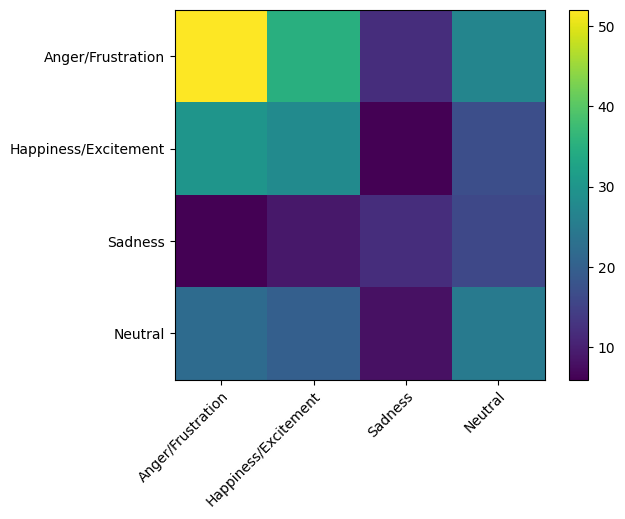

tensor(3.4118, dtype=torch.float64, grad_fn=<AddBackward0>)

In [ ]:
# Generates confusion matrix, test model on batched_test iterable

test_emomodel(model, batched_test)

In [ ]:
# Generates waveform plot

def plot_waveform(waveform, sample_rate, xlabel, ylabel, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  axes.set_ylabel(ylabel)
  axes.set_xlabel(xlabel)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

#waveform = iemocap_dataset.__getitem__(50)['waveform']
#waveform_plot = plot_waveform(waveform, 16000, 'Time in ms', 'Amplitude', title='Waveform') 

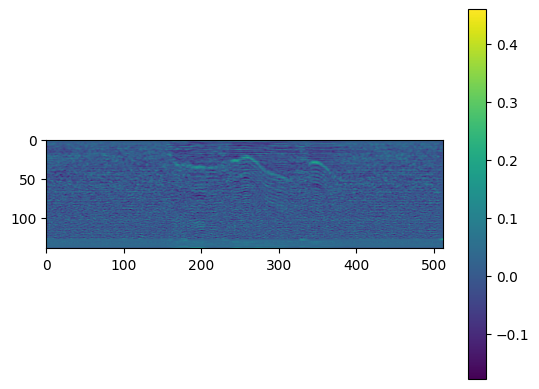

In [ ]:
# Generates featuremap for 1 sample

def plot_featuremap(tensor):
  tensor = torch.nn.functional.normalize(tensor, dim=1)
  data = tensor.numpy()
  fig, ax = plt.subplots()
  im = ax.imshow(data)
  cbar = ax.figure.colorbar(im, ax=ax)
  plt.show()

#matrix, _ = create_matrix(50, 512)
#plot_featuremap(torch.from_numpy(np.squeeze(matrix)))